# Factor Analysis of Mixed Data 
This notebook prints progress and explains each step. We standardize numeric, one-hot + standardize categoricals, then PCA to 10 components.


## 1) Imports, load & dtypes

In [3]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

train = pd.read_csv('../Data/train.csv'); train.columns=[c.strip() for c in train.columns]
test = pd.read_csv('../Data/test.csv');  test .columns=[c.strip() for c in test.columns]
print('Train shape:', train.shape, '| Test shape:', test.shape)
print('Dtypes:')
print(train.dtypes.sort_index())
target_col = next((c for c in ['Listening_Time_minutes','listening_time_minutes','target'] if c in train.columns), None)
id_col     = next((c for c in ['id','Id','ID','row_id'] if c in train.columns), None)
print('Detected target_col =', target_col, '| id_col =', id_col)

Train shape: (750000, 12) | Test shape: (250000, 11)
Dtypes:
Episode_Length_minutes         float64
Episode_Sentiment               object
Episode_Title                   object
Genre                           object
Guest_Popularity_percentage    float64
Host_Popularity_percentage     float64
Listening_Time_minutes         float64
Number_of_Ads                  float64
Podcast_Name                    object
Publication_Day                 object
Publication_Time                object
id                               int64
dtype: object
Detected target_col = Listening_Time_minutes | id_col = id


## 2) Split numeric vs categorical & impute

In [5]:
feat=[c for c in train.columns if c not in {target_col, id_col}]
df_all=pd.concat([train[feat], test[feat]], axis=0, ignore_index=True)
num=[c for c in df_all.columns if pd.api.types.is_numeric_dtype(df_all[c])]
cat=[c for c in df_all.columns if c not in num]
print('Numeric count:', len(num), '| Categorical count:', len(cat))
num_imp=SimpleImputer(strategy='median'); cat_imp=SimpleImputer(strategy='most_frequent')
df_num=pd.DataFrame(num_imp.fit_transform(df_all[num]), columns=num) if num else pd.DataFrame(index=df_all.index)
df_cat=pd.DataFrame(cat_imp.fit_transform(df_all[cat]), columns=cat) if cat else pd.DataFrame(index=df_all.index)
if len(df_num.columns):
    df_num=(df_num-df_num.mean(0))/(df_num.std(0).replace(0,1.0))
    print('Standardized numerics.')
if len(df_cat.columns):
    oh=pd.get_dummies(df_cat, drop_first=False)
    p=oh.mean(0).clip(1e-6,1-1e-6)
    scale=np.sqrt(p*(1-p))
    df_cat_std=(oh-p)/scale
    print('One-hot + MCA standardization done; dummies:', oh.shape[1])
else:
    df_cat_std=pd.DataFrame(index=df_all.index)
X=pd.concat([df_num, df_cat_std], axis=1)
print('Design matrix X:', X.shape)

Numeric count: 4 | Categorical count: 6
Standardized numerics.
One-hot + MCA standardization done; dummies: 172
Design matrix X: (1000000, 176)


## 3) PCA to 10 components & quick diagnostics

FAMD shapes → train: (750000, 10) | test: (250000, 10)
Explained variance ratio (first 10): [0.0123 0.0122 0.0122 0.0122 0.0122 0.0121 0.012  0.012  0.0119 0.0086]


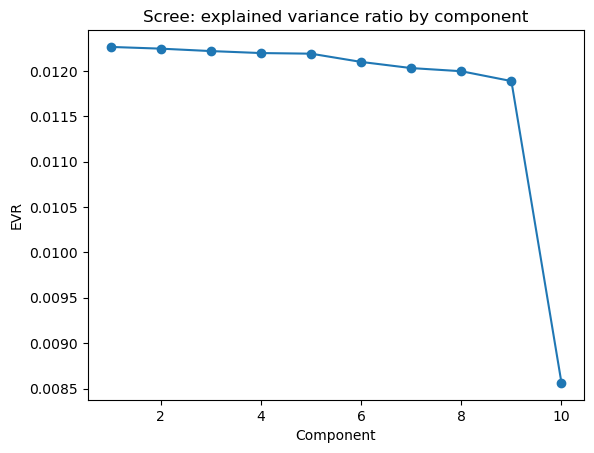

In [7]:
K=min(10, X.shape[1]) if X.shape[1] else 0
if K>0:
    pca=PCA(n_components=K, random_state=42)
    Z=pca.fit_transform(X.values)
    n=len(train)
    F_tr=pd.DataFrame(Z[:n], columns=[f'FAMD_{i+1}' for i in range(Z.shape[1])])
    F_te=pd.DataFrame(Z[n:],  columns=[f'FAMD_{i+1}' for i in range(Z.shape[1])])
    print('FAMD shapes → train:', F_tr.shape, '| test:', F_te.shape)
    # Scree (variance ratios)
    evr=pca.explained_variance_ratio_
    print('Explained variance ratio (first 10):', np.round(evr,4))
    plt.figure()
    plt.plot(range(1, len(evr)+1), evr, marker='o')
    plt.title('Scree: explained variance ratio by component')
    plt.xlabel('Component'); plt.ylabel('EVR')
    plt.show()
else:
    F_tr=pd.DataFrame(index=range(len(train))); F_te=pd.DataFrame(index=range(len(test)))
    print('No features to factor-analyze (X empty).')

## 4) (Optional) Correlation of factors with target (train)

In [9]:
if target_col and not F_tr.empty:
    y=train[target_col].values
    rows=[]
    for c in F_tr.columns:
        x=F_tr[c].values
        r=0.0 if np.std(x)==0 else float(np.corrcoef(y,x)[0,1])
        rows.append((c, r))
    rows=sorted(rows, key=lambda t: abs(t[1]), reverse=True)
    print('Top factor correlations with target:')
    for name, r in rows[:10]:
        print(f'  {name:8s} r={r: .4f}')

Top factor correlations with target:
  FAMD_10  r= 0.0203
  FAMD_8   r=-0.0182
  FAMD_4   r=-0.0100
  FAMD_2   r= 0.0078
  FAMD_3   r= 0.0061
  FAMD_1   r=-0.0055
  FAMD_6   r= 0.0046
  FAMD_9   r= 0.0030
  FAMD_7   r= 0.0028
  FAMD_5   r= 0.0009


## 5) Save outputs

In [17]:
F_tr.to_csv('../Data/famd_components_train.csv', index=False)
F_te.to_csv('../Data/famd_components_test.csv', index=False)
print('Saved famd_components_train.csv', F_tr.shape)
print('Saved famd_components_test.csv',  F_te.shape)

Saved famd_components_train.csv (750000, 10)
Saved famd_components_test.csv (250000, 10)
